# Parallel tempering demo

Parallel tempering is an MCMC algorithm in which multiple markov-chains are ran in parallel, each at a different 'temperature', with the positions of pairs of chains being exchanged periodically. The temperature of a chain transforms the distribution being sampled, such that the log-probability is divided by the chosen temperature. The effect is that for a chain with temperature `T=1` the distribution is unchanged, but as `T` is increased, the distribution is smoothed by reducing the log-probability difference between any two points. This smoothing allows markov-chains to explore the distribution more freely, and cover a much larger space in a given number of steps. Typically one chain is set to have `T=1`, with all others having higher temperatures.

Periodically, pairs of chains are selected at random, and their positions are exchanged if the proposed swap passes a metropolis-hastings test. These swaps allow lower-temperature chains to make larger jumps across the parameter space to other areas of high probability density which they are unlikely to reach otherwise.

As an example, lets first define a posterior with strongly separated areas of high density:

In [1]:
from numpy import log, sqrt, sin, arctan2, pi

# define a posterior with multiple separate peaks
def multimodal_posterior(theta):
    x,y = theta
    r = sqrt(x**2 + y**2)
    phi = arctan2(y,x)
    z = ((r - (0.5 + pi - phi*0.5))/0.1)
    return -0.5*z**2  + 4*log(sin(phi*2.)**2)

Next we need to choose a set of temperatures - a good rule of thumb is to space the temperatures logarithmically between 1 and some maximum temperature.

In [2]:
# required for multi-process code when running on windows
if __name__ == "__main__":

    # define a set of temperature levels
    N_levels = 6
    temps = [10**(2.5*k/(N_levels-1.)) for k in range(N_levels)]

Next choose one of the MCMC samplers from `inference.mcmc` and create an instance with each of the chosen temperature levels:

In [3]:
    from inference.mcmc import GibbsChain, ParallelTempering
    chains = [ GibbsChain( posterior=multimodal_posterior, start = [0.5,0.5], temperature=T) for T in temps ]

The `ParallelTempering` class takes the list of chains as input, and spawns a separate python process to manage each chain so that they can be advanced in parallel.

In [4]:
    PT = ParallelTempering(chains=chains)

`ParallelTempering` has the usual `advance` and `run_for` methods used to advance markov-chain objects, and communicates the instruction to each process.

In [5]:
    PT.run_for(minutes=0.5)

  [ Running ParallelTempering - complete! ]                    


We can recover a copy of the current state of each chain from the processes using the `return_chains()` method:

In [6]:
    chains = PT.return_chains()

By looking at the trace plot for the `T = 1` chain (i.e. the chain sampling from the untransformed distribution), we see that it makes large jumps across the parameter space due to the swaps.

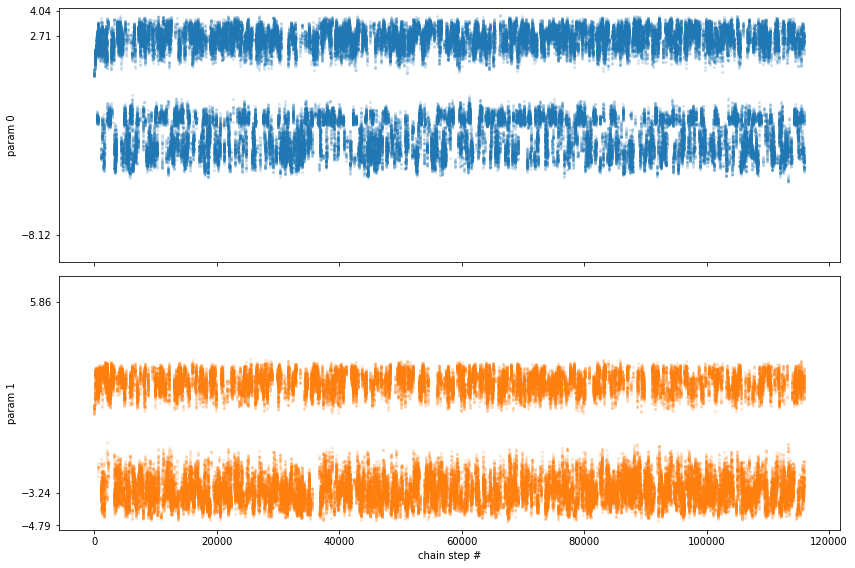

In [7]:
    chains[0].trace_plot()

Using `matrix_plot()`, we see that even though the posterior has strongly separated peaks, the `T = 1` chain was able to explore all of them due to the swaps.

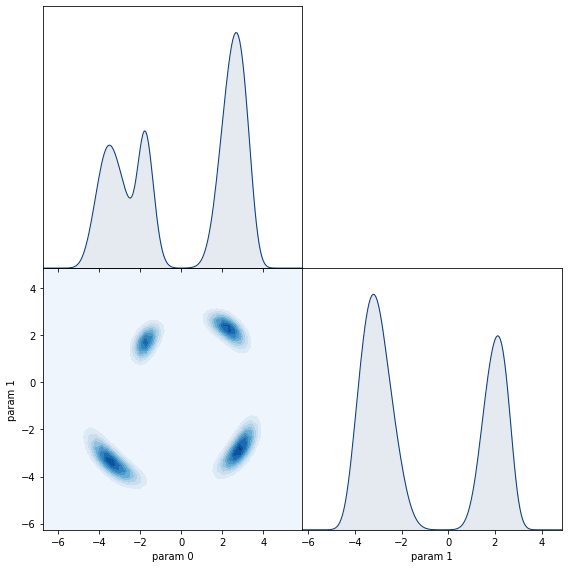

In [8]:
    chains[0].matrix_plot()

Because each process waits for instructions from the ParallelTempering object, they will not self-terminate while the parent process is still active. To terminate the processes we can trigger a shutdown event using the shutdown method:

In [9]:
    PT.shutdown()